In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from Bio.Phylo._io import parse
from Bio.Phylo.BaseTree import Tree as BioTree
from scipy import stats
import seaborn as sns
from tqdm import tqdm

from src.datasets.load_trees import load_trees_from_file
from src.utils.tree_utils import get_taxa_names
from src.utils.tree_utils import get_tree_height
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df

from scipy.stats import ks_2samp

from collections import Counter

In [3]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [4]:
POSTERIOR_DIR = Path("data/hpd_validation")
GRAPHS_DIR = Path("data/hpd_validation_analysis")

In [5]:
dict_true_tree_percentiles = {
    "model_name": [],
    "true_tree_percentile": [],
}

for posterior_file in tqdm(list(POSTERIOR_DIR.glob("*.log"))):   
    file_name_wo_ext = posterior_file.name.removesuffix(".log")
    dataset_name, model_name = file_name_wo_ext.split("_")
    
    posterior_df = pd.read_csv(posterior_file)

    assert posterior_df.iloc[0]["tree"] == "true"
    true_posterior = posterior_df.iloc[0]["posterior"]
    posterior_df = posterior_df.drop(posterior_df.index[0])

    dict_true_tree_percentiles["model_name"].append(model_name)
    dict_true_tree_percentiles["true_tree_percentile"].append(stats.percentileofscore(posterior_df.posterior, true_posterior))

df_true_tree_percentiles = pd.DataFrame(dict_true_tree_percentiles)

100%|██████████| 380/380 [00:01<00:00, 337.89it/s]


In [6]:
df_true_tree_percentiles["rounded_true_tree_percentile"] = df_true_tree_percentiles.true_tree_percentile.round(2)

In [7]:
df_true_tree_percentiles.groupby("model_name").mean()

,true_tree_percentile,rounded_true_tree_percentile
model_name,,
gamma-mu-sigma,47.954737,47.954737
gamma-mu-sigma-beta-old-old,47.635474,47.635474
mu-sigma,49.576316,49.576316
mu-sigma-beta-old-old,49.708737,49.708737


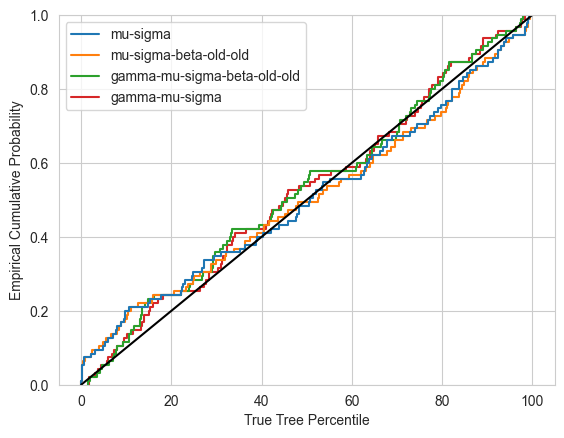

In [8]:
fig = sns.ecdfplot(
    df_true_tree_percentiles,
    x="true_tree_percentile",
    hue="model_name",
)

plt.xlabel("True Tree Percentile")
plt.ylabel("Empirical Cumulative Probability")

fig.get_legend().set_title("")

plt.plot([0, 100], [0, 1], color="black", linestyle="solid")

plt.show()

([0, 1, 2, 3],
 [Text(0, 0, 'gamma-mu-sigma'),
  Text(1, 0, 'mu-sigma'),
  Text(2, 0, 'mu-sigma-beta-old-old'),
  Text(3, 0, 'gamma-mu-sigma-beta-old-old')])

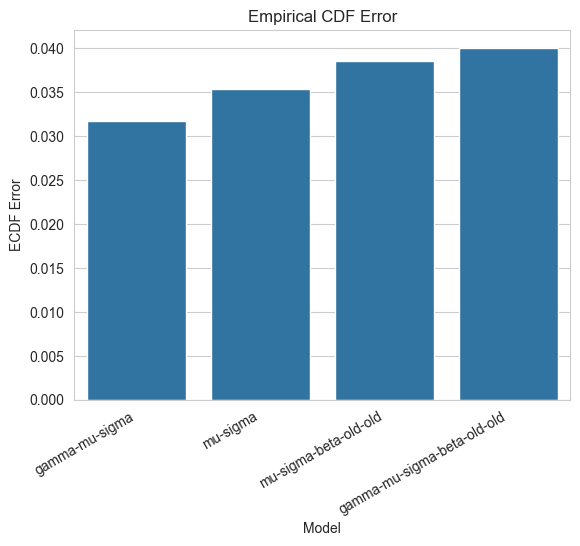

In [21]:
import scipy.stats as stats

def get_ecdf_error(samples):
    ecfd = stats.ecdf(samples).cdf

    error = 0

    for i in range(len(ecfd.quantiles) - 1):
        quantile_size = (ecfd.quantiles[i + 1] - ecfd.quantiles[i]) / 100
        error += quantile_size * abs(ecfd.quantiles[i] / 100 - ecfd.probabilities[i])

    return error

sns.barplot(
    df_true_tree_percentiles.groupby("model_name").apply(lambda x: get_ecdf_error(x.true_tree_percentile)).sort_values(),
    dodge=False
)

plt.title("Empirical CDF Error")
plt.xlabel("Model")
plt.ylabel("ECDF Error")
plt.xticks(rotation=30, ha="right")

In [10]:
df_true_tree_percentiles

,model_name,true_tree_percentile,rounded_true_tree_percentile
0,mu-sigma,52.11,52.11
1,mu-sigma,85.58,85.58
2,mu-sigma,38.90,38.90
3,mu-sigma-beta-old-old,91.82,91.82
4,mu-sigma,47.78,47.78
...,...,...,...
375,mu-sigma-beta-old-old,10.46,10.46
376,mu-sigma,15.34,15.34
377,mu-sigma,4.74,4.74
378,mu-sigma-beta-old-old,4.74,4.74


In [11]:
get_ecdf_error(df_true_tree_percentiles[df_true_tree_percentiles["model_name"] == "mu-sigma"].true_tree_percentile)

np.float64(0.035345304210526333)

In [12]:
from collections import Counter

c = Counter((df_true_tree_percentiles[df_true_tree_percentiles["model_name"] == "mu-sigma"].true_tree_percentile).floordiv(10)) 

cum = 0
err = 0
for i in range(10):
    cum += c[i] / len(df_true_tree_percentiles[df_true_tree_percentiles["model_name"] == "mu-sigma"])
    err += abs(cum - (i + 1) / 10) / 10

err

0.03526315789473685

In [13]:
len(df_true_tree_percentiles)

380

In [14]:
c[0] / len(df_true_tree_percentiles)

0.05

In [15]:
abs(c[0] / len(df_true_tree_percentiles) - (0 + 1) / 10) 

0.05